In [1]:
# Create a custom dataset with transformations applied
from torch.utils.data import DataLoader, Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        
        # Apply transform if available
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torchvision import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt

# Define the Encoder
class ConvCVAEEncoder(nn.Module):
    def __init__(self, latent_dim, label_dim):
        super(ConvCVAEEncoder, self).__init__()
        self.label_embedding = nn.Linear(label_dim, 28 * 28)
        self.conv1 = nn.Conv2d(2, 28, kernel_size=2, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(28, 56, kernel_size=2, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv3 = nn.Conv2d(56, 112, kernel_size=2, stride=1, padding=1)
        self.fc1 = nn.Linear(11200, 224)
        self.fc_z_mean = nn.Linear(224, latent_dim)
        self.fc_z_log_var = nn.Linear(224, latent_dim)

    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels).view(-1, 1, 28, 28)  # Reshape to match image channel dimension
        x = torch.cat([x, label_embedding], dim=1)  # Concatenate along the channel dimension
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        
        # print(x.shape)  # Add this to check the shape before the fully connected layer
    
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        z_mean = self.fc_z_mean(x)
        z_log_var = self.fc_z_log_var(x)
        return z_mean, z_log_var

class ConvCVAEDecoder(nn.Module):
    def __init__(self, latent_dim, label_dim):
        super(ConvCVAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim + label_dim, 7 * 7 * 64)
        self.conv1 = nn.ConvTranspose2d(64, 112, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.ConvTranspose2d(112, 56, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.ConvTranspose2d(56, 28, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.ConvTranspose2d(28, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, z, labels):
        x = torch.cat([z, labels], dim=1)
        x = torch.relu(self.fc(x))
        x = x.view(-1, 64, 7, 7)  # Reshape for convolution
        x = torch.relu(self.conv1(x))
        x = self.upsample1(x)
        x = torch.relu(self.conv2(x))
        x = self.upsample2(x)
        x = torch.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))  # Apply sigmoid to ensure output is between 0 and 1
        return x
    
# Full CVAE Model
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim, label_dim):
        super(ConvCVAE, self).__init__()
        self.encoder = ConvCVAEEncoder(latent_dim, label_dim)
        self.decoder = ConvCVAEDecoder(latent_dim, label_dim)
    
    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x, labels):
        z_mean, z_log_var = self.encoder(x, labels)
        z = self.reparameterize(z_mean, z_log_var)
        return self.decoder(z, labels), z_mean, z_log_var

# Loss Function
def loss_function(reconstructed_x, x, z_mean, z_log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_loss

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training and Validation Loop
def train_cvae(model, train_loader, val_loader, optimizer, epochs, device, num_classes):
    early_stopping = EarlyStopping(patience=10, delta=0.001)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data = data.to(device)
            target = torch.nn.functional.one_hot(target, num_classes=num_classes).float().to(device)
            optimizer.zero_grad()
            reconstructed_x, z_mean, z_log_var = model(data, target)
            loss = loss_function(reconstructed_x, data, z_mean, z_log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        val_loss = validate_cvae(model, val_loader, device, num_classes=2)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, Val Loss: {val_loss / len(val_loader.dataset):.4f}")
        

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

def validate_cvae(model, val_loader, device, num_classes):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = torch.nn.functional.one_hot(target, num_classes=num_classes).float().to(device)
            reconstructed_x, z_mean, z_log_var = model(data, target)
            val_loss += loss_function(reconstructed_x, data, z_mean, z_log_var).item()
    return val_loss

# Inference and Image Generation
def generate_images(model, label, latent_dim, num_classes, num_images=5, device='cpu'):
    model.eval()
    with torch.no_grad():
        label_tensor = torch.eye(num_classes)[[label] * num_images].to(device)
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decoder(z, label_tensor).cpu()
        generated_images = generated_images.view(num_images, 28, 28)

        plt.figure(figsize=(10, 5))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.show()

# # Data Preparation
# transform = transforms.Compose([transforms.ToTensor()])
# # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# 
# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# 
batch_size = 256
# 
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# 
# # Model, Optimizer, and Device
# latent_dim = 16
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ConvCVAE(latent_dim=latent_dim).to(device)
# optimizer = Adam(model.parameters(), lr=0.001)

In [3]:
# Train Model
# epochs = 5
# train_cvae(model, train_loader, val_loader, optimizer, epochs, device)

In [4]:
# Generate new images based on a label
# generate_images(model, label=4, latent_dim=latent_dim, num_images=5, device=device)

In [5]:
from KL.kl.utils import load_fx
window_size = 30
pair = 'EURUSD'
X, y, returns = load_fx(data_start=0, data_end=5000, window_size=window_size, shift=1, pair=pair)


In [6]:
from pyts.image import GramianAngularField
transformer = GramianAngularField()

X_new = transformer.transform(X)

X_new = X_new.astype('float32')
y = y.astype('int64')  # Ensure labels are in correct format
print(X_new.shape, y.shape, X_new.dtype, y.dtype)
print(X_new.min(), X_new.max(), y.min(), y.max())

(4970, 28, 28) (4970,) float32 int64
-1.0 1.0 0 1


In [7]:
# Modify the transform to convert data to float32
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,)),  # Normalize
    transforms.Lambda(lambda x: (x + 1) / 2),  # Rescale from [-1, 1] to [0, 1]
    transforms.Lambda(lambda x: x.float())  # Ensure data is in float32
])

dataset = CustomDataset(X_new, y, transform=transform)

# Define the sizes for train and validation split
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size   # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for both train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
latent_dim = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fx = ConvCVAE(latent_dim=latent_dim, label_dim=2).to(device)
optimizer = Adam(model_fx.parameters(), lr=0.001)
epochs = 200
train_cvae(model_fx, train_loader, val_loader, optimizer, epochs, device, num_classes=2)

Epoch 1, Train Loss: 429.8616, Val Loss: 390.1148
Epoch 2, Train Loss: 382.6198, Val Loss: 371.2801
Epoch 3, Train Loss: 371.2884, Val Loss: 367.1723
Epoch 4, Train Loss: 369.6861, Val Loss: 366.3271
Epoch 5, Train Loss: 369.0987, Val Loss: 365.4795
Epoch 6, Train Loss: 368.0409, Val Loss: 364.3188
Epoch 7, Train Loss: 365.7725, Val Loss: 362.3715
Epoch 8, Train Loss: 364.7710, Val Loss: 362.1905
Epoch 9, Train Loss: 364.6663, Val Loss: 361.9516
Epoch 10, Train Loss: 364.4333, Val Loss: 362.2750
Epoch 11, Train Loss: 364.3132, Val Loss: 361.5821
Epoch 12, Train Loss: 364.1678, Val Loss: 361.7905
Epoch 13, Train Loss: 364.3111, Val Loss: 362.3815
Epoch 14, Train Loss: 364.2024, Val Loss: 361.6979
Epoch 15, Train Loss: 364.1260, Val Loss: 361.5276
Epoch 16, Train Loss: 363.6675, Val Loss: 360.5324
Epoch 17, Train Loss: 363.1403, Val Loss: 360.6198
Epoch 18, Train Loss: 362.8850, Val Loss: 360.2281
Epoch 19, Train Loss: 362.4349, Val Loss: 359.6426
Epoch 20, Train Loss: 361.8712, Val Loss

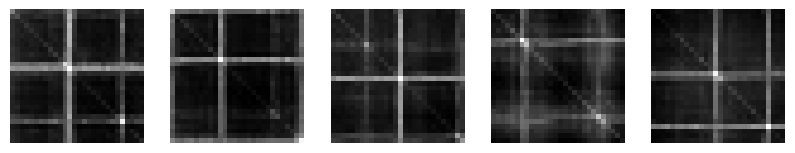

In [9]:
# Generate new images based on a label
generate_images(model_fx, label=0, num_classes=2, latent_dim=latent_dim, num_images=5, device=device)

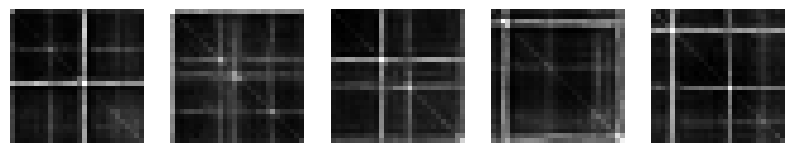

In [10]:
generate_images(model_fx, label=1, num_classes=2, latent_dim=latent_dim, num_images=5, device=device)

In [11]:
model_fx.eval()
num_classes = 2
label = 0
num_images = 1000
with torch.no_grad():
    label_tensor = torch.eye(num_classes)[[label] * num_images].to(device)
    z = torch.randn(num_images, latent_dim).to(device)
    generated_images = model_fx.decoder(z, label_tensor).cpu()
    generated_images = generated_images.view(num_images, 28, 28)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 is the output size after pooling twice
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the feature map
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training and validation function
def train_cnn(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, '
              f'Val Acc: {val_correct / val_total:.4f}')

# Load data and initialize the model, optimizer, and criterion
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize CNN, criterion, and optimizer
cnn_model = SimpleCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_cnn(cnn_model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Epoch 1/10, Train Loss: 0.6949, Train Acc: 0.4950, Val Loss: 0.6929, Val Acc: 0.5131
Epoch 2/10, Train Loss: 0.6943, Train Acc: 0.4977, Val Loss: 0.6930, Val Acc: 0.5151
Epoch 3/10, Train Loss: 0.6937, Train Acc: 0.5136, Val Loss: 0.6935, Val Acc: 0.4869
Epoch 4/10, Train Loss: 0.6933, Train Acc: 0.4990, Val Loss: 0.6940, Val Acc: 0.4759
Epoch 5/10, Train Loss: 0.6917, Train Acc: 0.5111, Val Loss: 0.6938, Val Acc: 0.5131
Epoch 6/10, Train Loss: 0.6911, Train Acc: 0.5229, Val Loss: 0.6941, Val Acc: 0.5020
Epoch 7/10, Train Loss: 0.6907, Train Acc: 0.5171, Val Loss: 0.6941, Val Acc: 0.5050
Epoch 8/10, Train Loss: 0.6868, Train Acc: 0.5420, Val Loss: 0.6985, Val Acc: 0.5111
Epoch 9/10, Train Loss: 0.6874, Train Acc: 0.5289, Val Loss: 0.6966, Val Acc: 0.5050
Epoch 10/10, Train Loss: 0.6814, Train Acc: 0.5566, Val Loss: 0.7045, Val Acc: 0.4869


In [ ]:
#Generate and save images
import torch
import os
from torchvision.utils import save_image

def generate_and_save_images(model, latent_dim, num_images_per_class, save_dir, num_classes=2, device='cpu'):
    model.eval()

    with torch.no_grad():
        for label in range(num_classes):
            label_dir = os.path.join(save_dir, f'class_{label}')
            os.makedirs(label_dir, exist_ok=True)
            
            label_tensor = torch.eye(num_classes)[[label] * num_images_per_class].to(device)
            z = torch.randn(num_images_per_class, latent_dim).to(device)
            generated_images = model.decoder(z, label_tensor).cpu()

            for i in range(num_images_per_class):
                if i%1000==0:
                    print(f'done{i}')
                img = generated_images[i].view(1, 28, 28)  # Reshape to 1x28x28 (grayscale)
                save_image(img, os.path.join(label_dir, f'class_{label}_img_{i}.png'))

# Example usage:
latent_dim = 16
num_images_per_class = 500  # Number of images per class
save_dir = './generated_images/'

generate_and_save_images(model_fx, latent_dim, num_images_per_class, save_dir, num_classes=2, device=device)

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Create a transform for loading images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure it's single-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the saved images
generated_dataset = datasets.ImageFolder(root=save_dir, transform=transform)

# Define the sizes for train and validation split
generated_train_size = int(0.8 * len(generated_dataset))  # 80% for training
generated_val_size = len(generated_dataset) - generated_train_size   # 20% for validation

generated_train_dataset, generated_val_dataset = random_split(generated_dataset, [generated_train_size, generated_val_size])

# Create DataLoader for the generated dataset
generated_train_loader = DataLoader(generated_train_dataset, batch_size=batch_size, shuffle=True)
generated_val_loader = DataLoader(generated_val_dataset, batch_size=batch_size, shuffle=True)
generated_loader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=True)

# Now you can train your CNN using this generated data

In [15]:
cnn_model = SimpleCNN(num_classes=2)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
# train_cnn(cnn_model, train_loader, generated_loader, criterion, optimizer, device, epochs=10)
train_cnn(cnn_model, generated_loader, train_loader, criterion, optimizer, device, epochs=100)
# train_cnn(cnn_model, generated_train_loader, generated_val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100, Train Loss: 0.7079, Train Acc: 0.4830, Val Loss: 0.6947, Val Acc: 0.4912
Epoch 2/100, Train Loss: 0.6943, Train Acc: 0.4970, Val Loss: 0.6934, Val Acc: 0.4912
Epoch 3/100, Train Loss: 0.6930, Train Acc: 0.5000, Val Loss: 0.6944, Val Acc: 0.4912
Epoch 4/100, Train Loss: 0.6945, Train Acc: 0.5000, Val Loss: 0.6947, Val Acc: 0.4912
Epoch 5/100, Train Loss: 0.6951, Train Acc: 0.4810, Val Loss: 0.6944, Val Acc: 0.4912
Epoch 6/100, Train Loss: 0.6934, Train Acc: 0.4960, Val Loss: 0.6968, Val Acc: 0.4912
Epoch 7/100, Train Loss: 0.6927, Train Acc: 0.5040, Val Loss: 0.6969, Val Acc: 0.4912
Epoch 8/100, Train Loss: 0.6921, Train Acc: 0.5240, Val Loss: 0.6970, Val Acc: 0.4912
Epoch 9/100, Train Loss: 0.6930, Train Acc: 0.5090, Val Loss: 0.6988, Val Acc: 0.4912
Epoch 10/100, Train Loss: 0.6918, Train Acc: 0.5150, Val Loss: 0.7032, Val Acc: 0.4912
Epoch 11/100, Train Loss: 0.6915, Train Acc: 0.5120, Val Loss: 0.7046, Val Acc: 0.4912
Epoch 12/100, Train Loss: 0.6897, Train Acc: 0.5430,

KeyboardInterrupt: 